In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent / "src"))

from torch.utils.data import DataLoader
from datetime import datetime
import csv
from pathlib import Path

from dataset.terramesh import build_terramesh_dataset, timestamp_to_str
from dataset.visualize import show_lulc, show_rgb


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_info(dataloader, split, save: bool = True, terminate: int = -1):

    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] START! Get img info from: {split}")

    if save:
        csv_path = Path(f"./info_{split}.csv")
        csv_file = open(csv_path, "w", newline='', encoding="utf-8")
        writer = csv.writer(csv_file)
        writer.writerow([
            'keys', 'S1_time', 'S2_time', 
            'LULC_1', 'LULC_7', 'LULC_8', 
            'lon', 'lat', 'x0', 'y0'
            ])
        
        written_count = 0    
    
    for idx, batch in enumerate(dataloader):

        # Condition checking and progress logging
        if idx % 1000 == 0:
            now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f"[{now}] {written_count}/{idx} samples written to CSV.")
        keys = list(batch.keys())
        if not ('time_S1RTC' in keys and 'time_S2RGB' in keys):
            continue
        if written_count >= terminate:
            break

        RGB = batch['S2RGB'].squeeze().byte()
        LULC = batch['LULC'].squeeze()

        # Get info
        info = {
            'keys': batch['__key__'][0],
            'time_ref':{
                'S1RTC': timestamp_to_str(int(batch['time_S1RTC'][0])) if 'time_S1RTC' in keys else None,
                'S2RGB': timestamp_to_str(int(batch['time_S2RGB'][0])) if 'time_S2RGB' in keys else None,
            },
            'lulc_ref':{
                'water': (LULC == 1).sum().item(),
                'snow_ice': (LULC == 7).sum().item(),
                'clouds': (LULC == 8).sum().item(),
            },
            'spatial_ref': {
                'lon_lat': (batch['center_lon'][0].item(), batch['center_lat'][0].item()),
                'x0_y0': (batch['x'][0].tolist()[0], batch['y'][0].tolist()[0]),
            },
        }

        # Quality check
        if info['lulc_ref']['snow_ice'] or info['lulc_ref']['clouds']:
            continue
        if info['lulc_ref']['water'] < 264*264*0.95:
            if info['lulc_ref']['water'] > 264*264*0.05:
                if save:
                    # write ordered row to CSV
                    row = [
                        info['keys'],
                        info['time_ref']['S1RTC'],
                        info['time_ref']['S2RGB'],
                        info['lulc_ref']['water'],
                        info['lulc_ref']['snow_ice'],
                        info['lulc_ref']['clouds'],
                        info['spatial_ref']['lon_lat'][0],
                        info['spatial_ref']['lon_lat'][1],
                        info['spatial_ref']['x0_y0'][0],
                        info['spatial_ref']['x0_y0'][1],
                    ]
                    writer.writerow(row)
                written_count += 1

    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if save:
        csv_file.close()
        print(f"[{now}] DONE! {written_count}/{idx} samples written to ./info_{split}.csv")
    else:
        print(f"[{now}] DONE! {written_count}/{idx} samples processed without saving.")


In [21]:
split = 'val'

dataset = build_terramesh_dataset(
    path="/dss/dsstbyfs02/scratch/07/di54rur/zeroflood/TerraMesh",  # Streaming or local path
    modalities=['S1RTC', "S2L2A", 'S2RGB', "LULC"], 
    split=split,
    shuffle=False,  # Set false for split="val"
    batch_size=1,
    return_metadata=True,
    time_dim=True,
)
dataloader = DataLoader(dataset, 
                        batch_size=None, 
                        num_workers=1, 
                        persistent_workers=True, 
                        prefetch_factor=1)

get_info(dataloader, split, terminate=10)

[2026-01-30 00:01:46] START! Get img info from: val


/dss/dsshome1/07/di54rur/.conda/mamba/envs/zeroflood/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:288: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


[2026-01-30 00:01:46] 0/0 samples written to CSV.
[2026-01-30 00:01:53] DONE! 10/279 samples written to ./info_val.csv


In [ ]:
# # If you only pass one modality, the modality is loaded with the "image" key
# dataset = build_terramesh_dataset(
#     path="/dss/dsstbyfs02/scratch/07/di54rur/zeroflood/TerraMesh",  # Streaming or local path
#     modalities=['S1RTC', "S2L2A", 'S2RGB', 'LULC'],  # List of modalities to load
#     split="val",
#     shuffle=False,  # Set false for split="val"
#     batch_size=1,
#     return_metadata=True,
#     time_dim=True,
# )

# dataloader = DataLoader(dataset, 
#                         batch_size=None, 
#                         num_workers=1, 
#                         persistent_workers=True, 
#                         prefetch_factor=1)

# infos = []
# for idx, batch in enumerate(dataloader):

#     keys = list(batch.keys())
    
#     # Condition checking and progress logging
#     if idx % 100 == 0:
#         now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#         print(f"[{now}] {len(infos)}/{idx} samples processed.")
#     if not ('time_S1RTC' in keys and 'time_S2RGB' in keys):
#         continue
#     if len(infos) > 10:
#         break
    
#     RGB = batch['S2RGB'].squeeze().byte()
#     LULC = batch['LULC'].squeeze()
#     info = {
#         'keys': batch['__key__'][0],
#         'time_ref':{
#             'S1RTC': timestamp_to_str(int(batch['time_S1RTC'][0])) if 'time_S1RTC' in keys else None,
#             'S2RGB': timestamp_to_str(int(batch['time_S2RGB'][0])) if 'time_S2RGB' in keys else None,
#             # 'LULC': timestamp_to_str(int(batch['time_LULC'][0])) if 'time_LULC' in keys else None,
#         },
#         'lulc_ref':{
#             # 'data': (RGB, LULC),
#             'water': (LULC == 1).sum().item(),
#             'snow_ice': (LULC == 7).sum().item(),
#             'clouds': (LULC == 8).sum().item(),
#         },
#         'spatial_ref': {
#             'lon_lat': (batch['center_lon'][0].item(), batch['center_lat'][0].item()),
#             'x0_y0': (batch['x'][0].tolist()[0], batch['y'][0].tolist()[0]),
#         },
#     }

#     if info['lulc_ref']['snow_ice'] or info['lulc_ref']['clouds']:
#         continue

#     if info['lulc_ref']['water'] < 264*264*0.95:
#         if info['lulc_ref']['water'] > 264*264*0.05:
#             infos.append(info)

/dss/dsshome1/07/di54rur/.conda/mamba/envs/zeroflood/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:288: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


[2026-01-29 12:32:36] 0/0 samples processed.
[2026-01-29 12:32:38] 3/100 samples processed.
[2026-01-29 12:32:40] 5/200 samples processed.


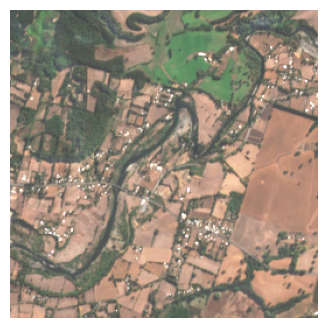

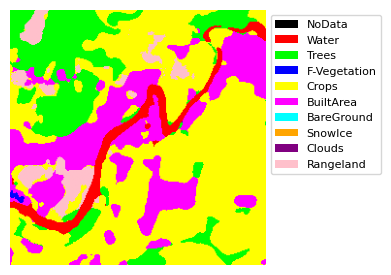

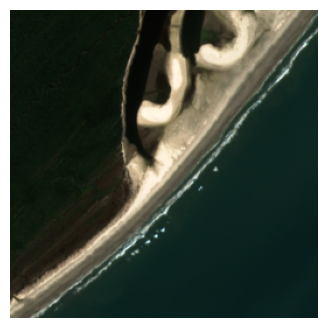

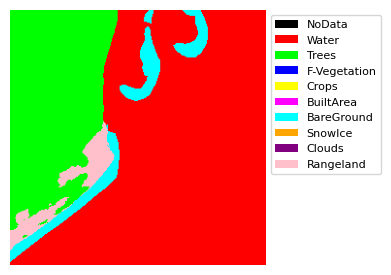

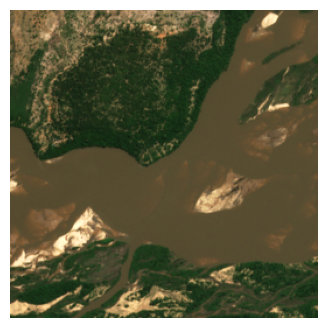

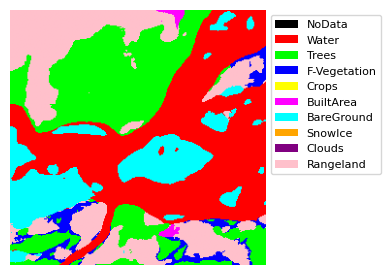

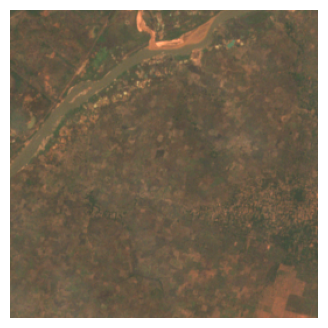

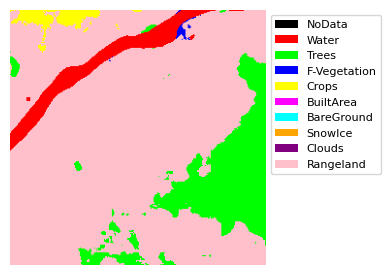

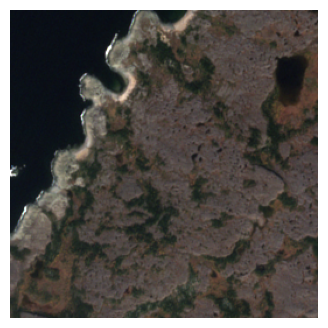

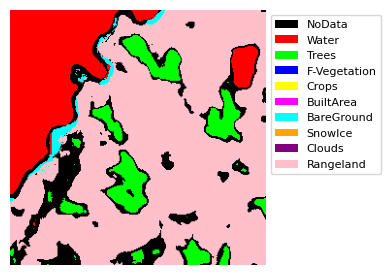

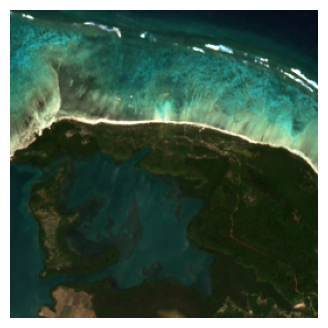

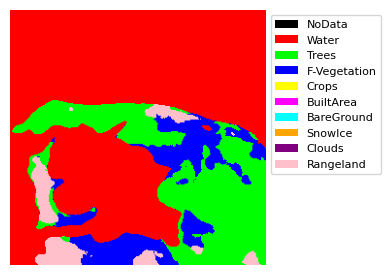

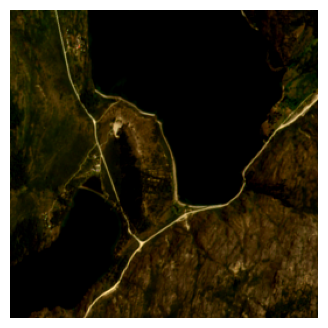

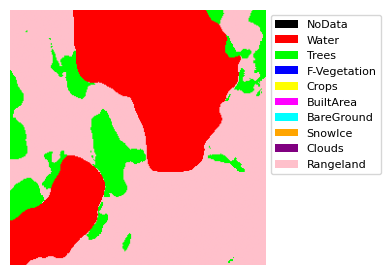

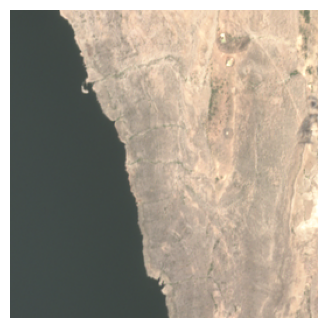

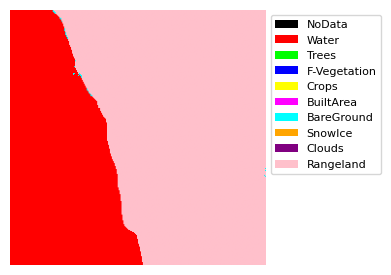

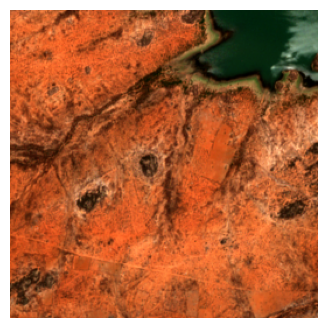

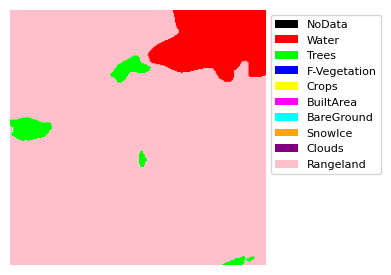

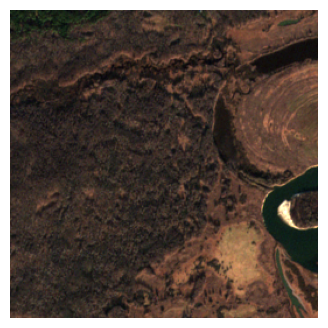

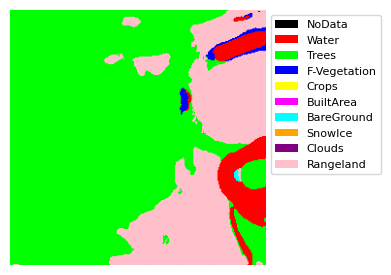

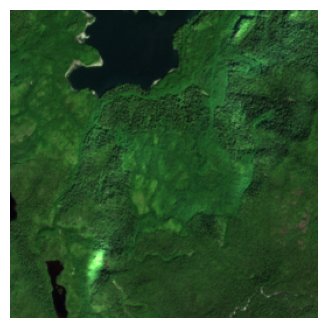

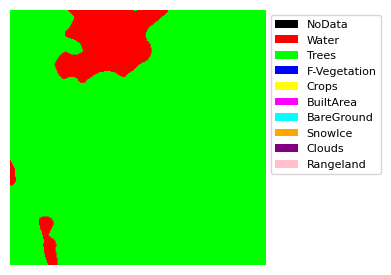

In [80]:
for info in infos:
    RGB, LULC = info['lulc_ref']['data']
    show_rgb(RGB)
    show_lulc(LULC)